In [1]:
import numpy as np
import pandas as pd
import importlib
import simulate_data
from matplotlib import pyplot as plt
from scipy.stats import beta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest
from econml.metalearners import SLearner, TLearner

importlib.reload(simulate_data)

<module 'simulate_data' from 'D:\\Delft\\Year 3\\Q4\\code\\research-project\\simulate_data.py'>

# Example Simulation
Balanced case with simple CATE

In [5]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n = 20000

sim = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n))

sim_y = sim["Y"]
sim_w = sim["W"]
sim_x = pd.DataFrame(sim["X"].tolist(), index = sim.index)
sim_x.columns = sim_x.columns.astype(str)
sim_x_s = sim_x.assign(W=pd.Series(sim_w).values)

sim_x_t_0 = pd.DataFrame(sim.query("W==0")["X"].tolist())
sim_x_t_0.columns = sim_x_t_0.columns.astype(str)
sim_x_t_1 = pd.DataFrame(sim.query("W==1")["X"].tolist())
sim_x_t_1.columns = sim_x_t_1.columns.astype(str)

print(sim_y[0])

sim_x_t_0

-3.944317021396696


,0,1,2,3,4
0,0.723912,-0.294426,-0.946852,-0.813664,0.790390
1,1.731294,-1.957139,-0.695270,0.268664,0.127038
2,-0.101421,-1.252416,-0.670513,1.752010,-0.266864
3,-0.022757,-0.038344,-1.332667,-1.059423,0.988625
4,-0.398214,0.790799,-0.767211,-0.223877,0.577352
...,...,...,...,...,...
9970,-1.414651,-0.418331,0.802987,-0.275783,-0.050715
9971,1.368097,-0.153701,1.819495,0.485903,-0.278702
9972,0.299007,0.601058,-0.940802,-1.567077,-0.485962
9973,0.134054,0.605420,-0.303320,-0.265771,0.375521


## S-learner

In [7]:
# regr = RandomForestRegressor(n_estimators=30, min_samples_split=10)
regr = RandomForestRegressor()
# regr = LinearRegression()
regr.fit(sim_x_s, sim_y)

y_fitted = regr.predict(sim_x_s)
print(y_fitted[0])
mean_squared_error(sim_y, y_fitted)

-4.046277495180987


0.10309932696508149

In [8]:
sim_test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, 1000))

sim_test_x = pd.DataFrame(sim_test["X"].tolist(), index=sim_test.index)
sim_test_x.columns = sim_test_x.columns.astype(str)

test_sim_x_0 = sim_test_x.assign(**{"W": 0})
test_sim_x_1 = sim_test_x.assign(**{"W": 1})
test_sim_y = np.append(sim_test["Y0"], sim_test["Y1"])

y_test_pred = regr.predict(pd.concat([test_sim_x_0, test_sim_x_1]))
mean_squared_error(test_sim_y, y_test_pred)


0.6212214640061823

In [52]:
# def sensitivity(data, y, t):
#         # line coefficient for the one variable linear regression
#         return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
#                 np.sum((data[t] - data[t].mean())**2))
#
# def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
#     size = dataset.shape[0]
#     ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
#     n_rows = list(range(min_periods, size, size // steps)) + [size]
#
#     ## add (rows/size) as a normalizer.
#     return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [53]:
s_learner_cate_train = (regr.predict(sim_x.assign(**{"W": 1})) -
                        regr.predict(sim_x.assign(**{"W": 0})))

s_learner_cate_test = sim_test_x.assign(
    cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
          regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
)

In [54]:
s_learner_cate_test

,0,1,2,3,4,cate
0,1.906479,-1.422016,0.061992,-0.110012,1.337015,21.553872
1,-1.627069,-0.150613,-1.233091,-0.578957,-0.053659,20.280326
2,0.329618,0.054917,-2.085093,-0.683112,1.577652,20.331823
3,1.369106,1.516700,-0.074604,1.289731,1.076611,21.289289
4,-0.013231,-0.626684,1.127084,-0.462074,-0.267188,19.496389
...,...,...,...,...,...,...
995,-1.451578,-0.443544,1.372372,0.873359,0.935981,18.997822
996,0.185442,-2.650209,-1.275243,-1.708890,-0.671137,18.885035
997,-0.634834,-1.111070,0.479719,0.217658,0.155431,19.986921
998,0.453531,-0.056021,-0.682778,0.490544,-0.309325,20.726422


In [55]:
mean_squared_error(s_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.6449526660417257

# T-learner

In [56]:
regr0 = RandomForestRegressor()
regr1 = RandomForestRegressor()

regr0.fit(sim_x_t_0, sim.query("W==0")["Y"])
regr1.fit(sim_x_t_1, sim.query("W==1")["Y"])

t_learner_cate_train = regr1.predict(sim_x) - regr0.predict(sim_x)
t_learner_cate_test = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))

In [57]:
t_learner_cate_test

,0,1,2,3,4,cate
0,1.906479,-1.422016,0.061992,-0.110012,1.337015,20.975349
1,-1.627069,-0.150613,-1.233091,-0.578957,-0.053659,20.448615
2,0.329618,0.054917,-2.085093,-0.683112,1.577652,20.344437
3,1.369106,1.516700,-0.074604,1.289731,1.076611,20.616876
4,-0.013231,-0.626684,1.127084,-0.462074,-0.267188,19.823680
...,...,...,...,...,...,...
995,-1.451578,-0.443544,1.372372,0.873359,0.935981,19.243994
996,0.185442,-2.650209,-1.275243,-1.708890,-0.671137,18.713505
997,-0.634834,-1.111070,0.479719,0.217658,0.155431,20.120759
998,0.453531,-0.056021,-0.682778,0.490544,-0.309325,20.820814


In [58]:
mean_squared_error(t_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.6290748144490013

In [59]:
cau_forest = CausalForest()
cau_forest.fit(sim_x, sim_w, sim_y)

ret = cau_forest.predict(sim_test_x)
ret

array([[20.6070563 ],
       [19.09291058],
       [19.91254239],
       [20.33112248],
       [19.83887117],
       [19.69571668],
       [19.88716596],
       [20.15040976],
       [20.49530814],
       [20.02795029],
       [20.30455719],
       [20.43072112],
       [19.66116161],
       [19.67769613],
       [19.68956784],
       [19.24710135],
       [20.24221521],
       [19.78796008],
       [19.5005531 ],
       [20.33295345],
       [20.20627534],
       [19.97449909],
       [20.26814759],
       [19.41873181],
       [20.1261749 ],
       [19.89895221],
       [20.01992337],
       [18.99806848],
       [20.02616725],
       [20.05133218],
       [19.90561151],
       [20.2797118 ],
       [19.55690176],
       [19.76019853],
       [19.80012458],
       [19.88798745],
       [20.48610904],
       [20.53157625],
       [19.63796317],
       [20.30887095],
       [19.72647353],
       [20.08564234],
       [20.02013208],
       [20.00208114],
       [20.6011174 ],
       [20

In [60]:
mean_squared_error(ret, sim_test.Y1 - sim_test.Y0)

0.16995791319819223

SIZE 100
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 200
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 300
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 500
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 750
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 1000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 2000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 5000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 10000
FINISHED S-Learner
FINISHED T-Learner
FINI

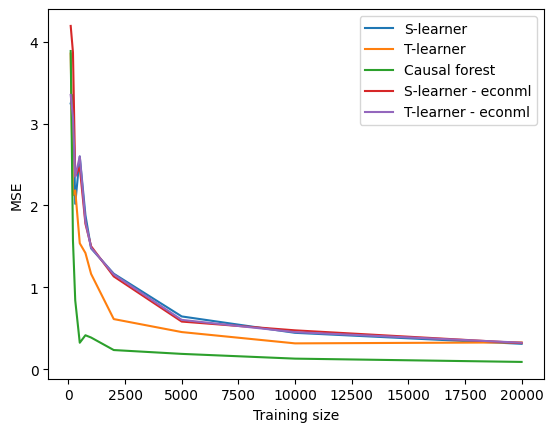

In [9]:
training_sizes = [100, 200, 300, 500, 750, 1000, 2000, 5000, 10000, 20000]
mse_s = []
mse_t = []
mse_forest = []
mse_econml_s = []
mse_econml_t = []
for size in training_sizes:
    print("SIZE " + str(size))
    # S-learner
    regr = RandomForestRegressor()
    regr.fit(sim_x_s.head(size), sim_y.head(size))
    s_learner_cate = sim_test_x.assign(
        cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
            regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
    )
    mse_s.append(mean_squared_error(s_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED S-Learner")

    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(sim_x_t_0.head(size), sim.query("W==0")["Y"].head(size))
    regr1.fit(sim_x_t_1.head(size), sim.query("W==1")["Y"].head(size))
    t_learner_cate = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))
    mse_t.append(mean_squared_error(t_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED T-Learner")

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(sim_x.head(size), sim_w.head(size), sim_y.head(size))
    causal_forest_cate = cau_forest.predict(sim_test_x)
    mse_forest.append(mean_squared_error(causal_forest_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED Causal Forest")

    econml_s = SLearner(overall_model=RandomForestRegressor())
    econml_s.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_s_cate = econml_s.effect(sim_test_x)
    mse_econml_s.append(mean_squared_error(econml_s_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED econ s-learner")

    econml_t = TLearner(models=RandomForestRegressor())
    econml_t.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_t_cate = econml_t.effect(sim_test_x)
    mse_econml_t.append(mean_squared_error(econml_t_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED econ t-learner")

plt.plot(training_sizes, mse_s, label="S-learner")
plt.plot(training_sizes, mse_t, label="T-learner")
plt.plot(training_sizes, mse_forest, label="Causal forest")
plt.plot(training_sizes, mse_econml_s, label="S-learner - econml")
plt.plot(training_sizes, mse_econml_t, label="T-learner - econml")
plt.ylabel("MSE")
plt.xlabel("Training size")
plt.legend()
plt.show()

# Testing setup

In [62]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [2]:
def train_and_evaluate(train, test, train_x_t_0_head, train_x_t_1_head):

    train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
    train_x.columns = train_x.columns.astype(str)
    train_y = train["Y"]
    train_w = train["W"]

    train_x_s = train_x.assign(W=pd.Series(train_w).values)
    train_x_t_0 = pd.DataFrame(train.query("W==0")["X"].tolist())
    train_x_t_0.columns = train_x_t_0.columns.astype(str)
    train_y_t_0 = train.query("W==0")["Y"]
    if train_x_t_0.shape[0] == 0:
        row = train_x_t_0_head
        train_x_t_0 = pd.DataFrame(row["X"].tolist())
        train_x_t_0.columns = train_x_t_0.columns.astype(str)
        train_y_t_0 = row["Y"]

    train_x_t_1 = pd.DataFrame(train.query("W==1")["X"].tolist())
    train_x_t_1.columns = train_x_t_1.columns.astype(str)
    train_y_t_1 = train.query("W==1")["Y"]
    if train_x_t_1.shape[0] == 0:
        row = train_x_t_1_head
        train_x_t_1 = pd.DataFrame(row["X"].tolist())
        train_x_t_1.columns = train_x_t_1.columns.astype(str)
        train_y_t_1 = row["Y"]

    test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
    test_x.columns = test_x.columns.astype(str)

    true_test_cate = test.Y1 - test.Y0
    # print("COPIED TABLES")

    # S-learner
    regr = RandomForestRegressor()
    regr.fit(train_x_s, train_y)

    s_learner_cate = regr.predict(test_x.assign(**{"W": 1})) - regr.predict(test_x.assign(**{"W": 0}))

    mse_s = mean_squared_error(s_learner_cate, true_test_cate)

    # print("TRAINED S-LEARNER")

    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(train_x_t_0, train_y_t_0)
    regr1.fit(train_x_t_1, train_y_t_1)

    t_learner_cate = regr1.predict(test_x) - regr0.predict(test_x)
    mse_t = mean_squared_error(t_learner_cate, true_test_cate)
    # print("TRAINED T-LEARNER")

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(train_x, train_w, train_y)

    causal_forest_cate = cau_forest.predict(test_x)
    mse_forest = mean_squared_error(causal_forest_cate, true_test_cate)

    return mse_s, mse_t, mse_forest

In [73]:
def run_test(d, mu_0, mu_1, e, n_train, n_test, reps):
    #               sim_x, sim_w, sim_y, sim_test_x, sim_test

    # training_sizes = [100, 200, 300, 500, 750, 1000, 2000]
    t_s = [0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1.0]
    training_sizes = [int(n_train * i) for i in t_s]
    mse_s = [[] for _ in training_sizes]
    mse_t = [[] for _ in training_sizes]
    mse_forest = [[] for _ in training_sizes]

    for r in range(reps):
        # print("REP " + str(r))
        # for size in training_sizes:
        #     mse_s = []
        #     mse_t = []
        #     mse_forest = []
        train_full = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
        test_full = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))
        for i, size in enumerate(training_sizes):
            # print("SIZE " + str(size))
            # for i in range(reps):

            # train = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
            # test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))
            train = train_full.head(size)
            test = test_full

            train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
            train_x.columns = train_x.columns.astype(str)
            train_y = train["Y"]
            train_w = train["W"]

            train_x_s = train_x.assign(W=pd.Series(train_w).values)
            train_x_t_0 = pd.DataFrame(train.query("W==0")["X"].tolist())
            train_x_t_0.columns = train_x_t_0.columns.astype(str)
            train_y_t_0 = train.query("W==0")["Y"]
            if train_x_t_0.shape[0] == 0:
                row = train_full.query("W==0").head(1)
                train_x_t_0 = pd.DataFrame(row["X"].tolist())
                train_x_t_0.columns = train_x_t_0.columns.astype(str)
                train_y_t_0 = row["Y"]

            train_x_t_1 = pd.DataFrame(train.query("W==1")["X"].tolist())
            train_x_t_1.columns = train_x_t_1.columns.astype(str)
            train_y_t_1 = train.query("W==1")["Y"]
            if train_x_t_1.shape[0] == 0:
                row = train_full.query("W==1").head(1)
                train_x_t_1 = pd.DataFrame(row["X"].tolist())
                train_x_t_1.columns = train_x_t_1.columns.astype(str)
                train_y_t_1 = row["Y"]

            test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
            test_x.columns = test_x.columns.astype(str)

            true_test_cate = test.Y1 - test.Y0
            # print("COPIED TABLES")

            # S-learner
            regr = RandomForestRegressor()
            regr.fit(train_x_s, train_y)

            # s_learner_cate = test_x.assign(
            #     cate=(regr.predict(test_x.assign(**{"W": 1})) - # predict under treatment
            #         regr.predict(test_x.assign(**{"W": 0}))) # predict under control
            # )
            # mse_s[i].append(mean_squared_error(s_learner_cate.cate, true_test_cate))
            s_learner_cate = regr.predict(test_x.assign(**{"W": 1})) - regr.predict(test_x.assign(**{"W": 0}))

            mse_s[i].append(mean_squared_error(s_learner_cate, true_test_cate))

            # print("TRAINED S-LEARNER")

            # T-learner
            regr0 = RandomForestRegressor()
            regr1 = RandomForestRegressor()
            regr0.fit(train_x_t_0, train_y_t_0)
            regr1.fit(train_x_t_1, train_y_t_1)

            # t_learner_cate = test_x.assign(cate=regr1.predict(test_x) - regr0.predict(test_x))
            # mse_t[i].append(mean_squared_error(t_learner_cate.cate, true_test_cate))
            t_learner_cate = regr1.predict(test_x) - regr0.predict(test_x)
            mse_t[i].append(mean_squared_error(t_learner_cate, true_test_cate))
            # print("TRAINED T-LEARNER")

            # Causal forest
            cau_forest = CausalForest()
            cau_forest.fit(train_x, train_w, train_y)

            causal_forest_cate = cau_forest.predict(test_x)
            mse_forest[i].append(mean_squared_error(causal_forest_cate, true_test_cate))
            # print("TRAINED CAUSAL FOREST")

        # mse_s_final.append(np.mean(mse_s))
        # mse_t_final.append(np.mean(mse_t))
        # mse_forest_final.append(np.mean(mse_forest))

    mse_s_final = list(map(lambda l: np.mean(l), mse_s))
    mse_t_final = list(map(lambda l: np.mean(l), mse_t))
    mse_forest_final = list(map(lambda l: np.mean(l), mse_forest))


    plt.plot(training_sizes, mse_s_final, label="S-learner")
    plt.plot(training_sizes, mse_t_final, label="T-learner")
    plt.plot(training_sizes, mse_forest_final, label="Causal forest")
    plt.ylabel("MSE")
    plt.xlabel("Training size")
    plt.legend()
    plt.show()

In [3]:
def get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, reps):
    mse_s_all = []
    mse_t_all = []
    mse_forest_all = []

    for i in range(reps):
        train_full = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
        test_full = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

        mse_s, mse_t, mse_forest = train_and_evaluate(train_full, test_full, train_full.query("W==0").head(1), train_full.query("W==1").head(1))

        mse_s_all.append(mse_s)
        mse_t_all.append(mse_t)
        mse_forest_all.append(mse_forest)

    data = {"S-Learner": [np.mean(mse_s_all), np.std(mse_s_all, ddof=1)], "T-Learner": [np.mean(mse_t_all), np.std(mse_t_all, ddof=1)], "Causal Forest": [np.mean(mse_forest_all), np.std(mse_forest_all, ddof=1)] }

    return pd.DataFrame.from_dict(data, orient='index', columns=["Mean", "Std dev"])


In [64]:
def plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test):
    train = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
    test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

    train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
    train_x.columns = train_x.columns.astype(str)

    test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
    test_x.columns = test_x.columns.astype(str)

    cau_forest = CausalForest()
    cau_forest.fit(train_x, train["W"], train["Y"])

    causal_forest_cate_train = train_x.assign(cate=cau_forest.predict(train_x), W=train["W"], Y=train["Y"])
    causal_forest_cate_test = test_x.assign(cate=cau_forest.predict(test_x), W=test["W"], Y=test["Y"])
    # mse_forest.append(mean_squared_error(causal_forest_cate, true_test_cate))
    # print(causal_forest_cate_train)
    # print(causal_forest_cate_test)

    gain_curve_test = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")
    gain_curve_train = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
    plt.plot(gain_curve_test, color="C0", label="Test")
    plt.plot(gain_curve_train, color="C1", label="Train")
    plt.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    plt.legend()
    plt.title("Cumulative gain curve")
    plt.show()

# Case 1

Balanced, with simple cate

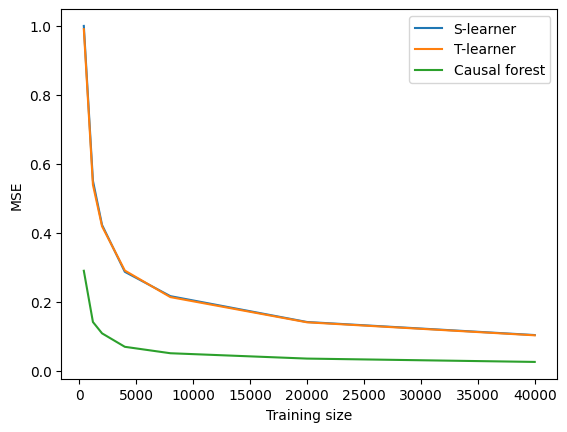

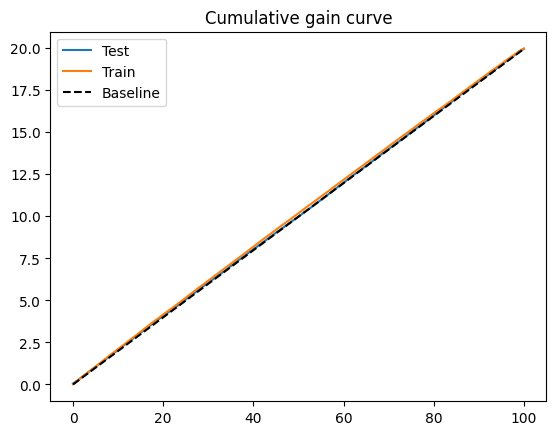

In [65]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [10]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,0.200251,0.009551
T-Learner,0.200925,0.006532
Causal Forest,0.048962,0.002266


# Case 2

Unbalanced, simple cate

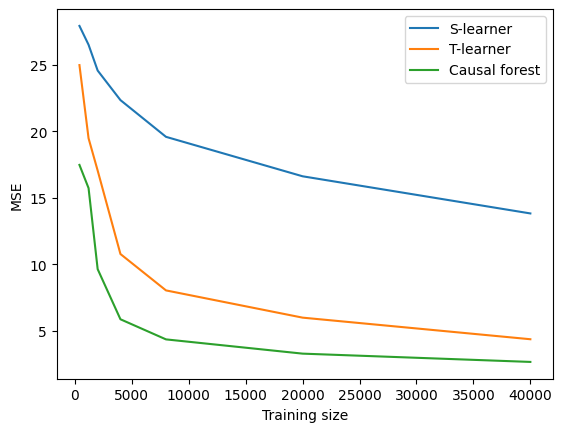

invalid value encountered in scalar divide


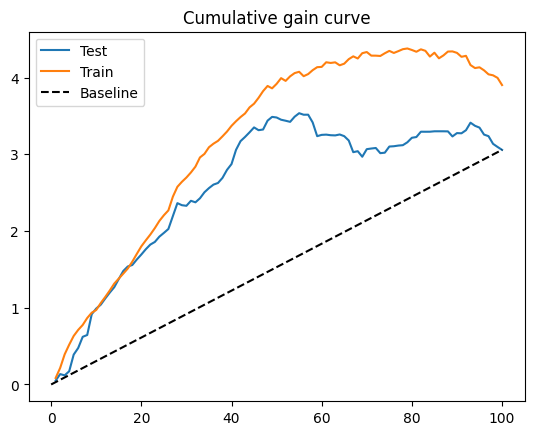

In [74]:
e = lambda x: 0.01
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) + 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 8 * (1 if x[1] > 0.1 else 0)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [11]:
e = lambda x: 0.01
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) + 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 8 * (1 if x[1] > 0.1 else 0)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,15.802064,0.857811
T-Learner,3.289242,0.229463
Causal Forest,8.088883,0.480518


# Case 3

Balanced, complex linear cate, no confounding

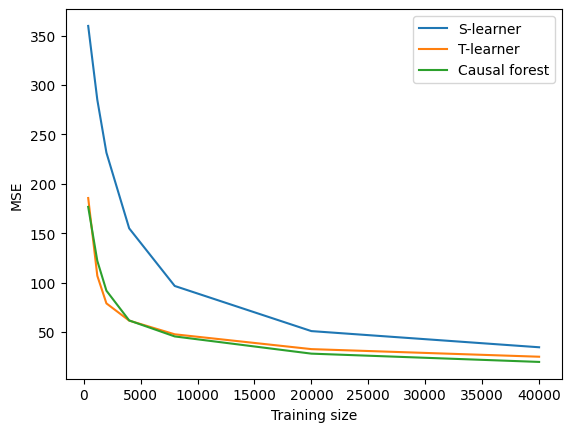

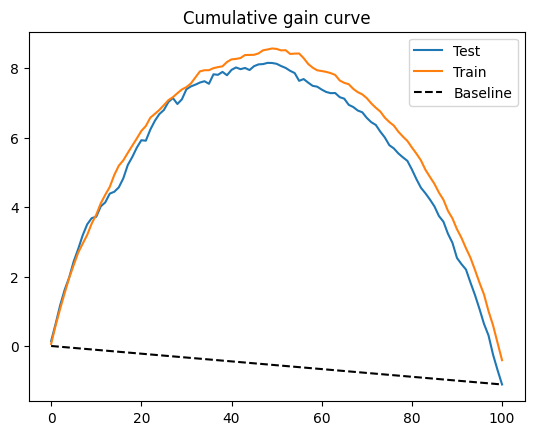

In [75]:
e = lambda x: 0.5
d = 5
weights_1 = np.random.uniform(1, 30, d)
weights_2 = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights_1)
mu_1 = lambda x: np.dot(x, weights_2)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [17]:
e = lambda x: 0.5
d = 5
weights_1 = np.random.uniform(1, 30, d)
weights_2 = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights_1)
mu_1 = lambda x: np.dot(x, weights_2)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,15.753132,0.950499
T-Learner,16.158448,0.409088
Causal Forest,36.219116,1.829192


# Case 4

Balanced, complex non-liner cate, no confounding

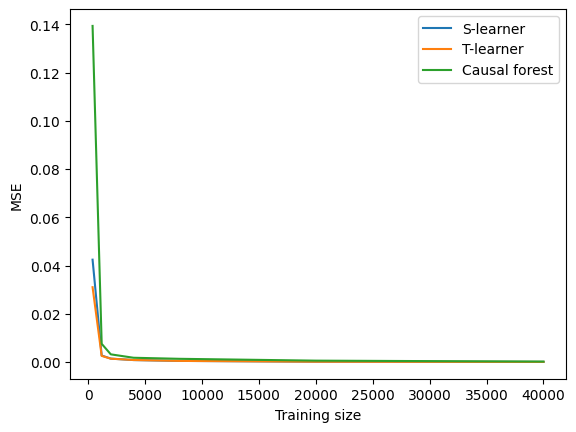

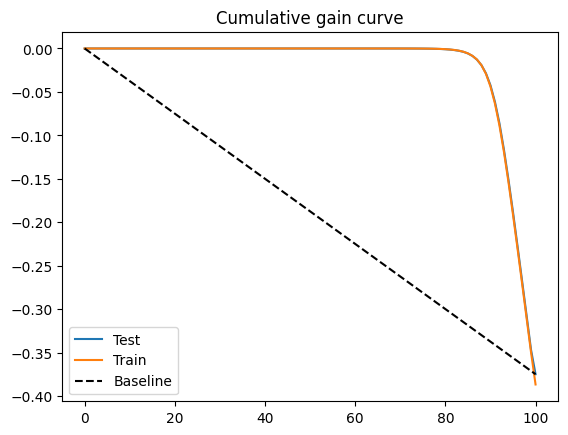

In [76]:
e = lambda x: 0.5
d = 5
fun = lambda x : 2.0 / (1 + np.exp(-12 * (x - 0.5)))
mu_0 = lambda x: 0.5 * fun(x[0]) * fun(x[1])
mu_1 = lambda x: -0.5 * fun(x[0]) * fun(x[1])
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [13]:
e = lambda x: 0.5
d = 5
fun = lambda x : 2.0 / (1 + np.exp(-12 * (x - 0.5)))
mu_0 = lambda x: 0.5 * fun(x[0]) * fun(x[1])
mu_1 = lambda x: -0.5 * fun(x[0]) * fun(x[1])
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,0.000052,0.000008
T-Learner,0.000053,0.000007
Causal Forest,0.000207,0.000036


# Case 5

Balanced, no treatment effect

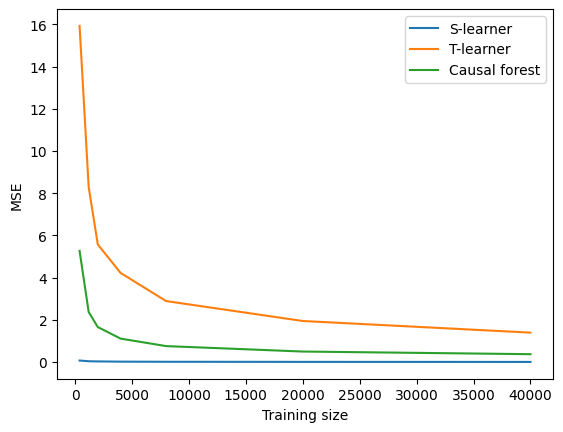

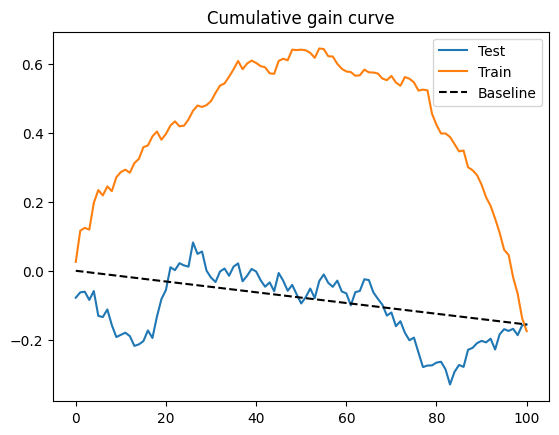

In [77]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [14]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,0.045986,0.003675
T-Learner,8.523772,0.391276
Causal Forest,2.104693,0.120849


# Case 6

Balanced, no treatment effect, piecewise function

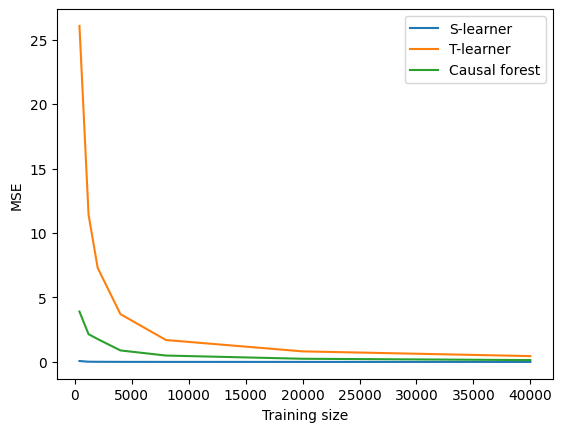

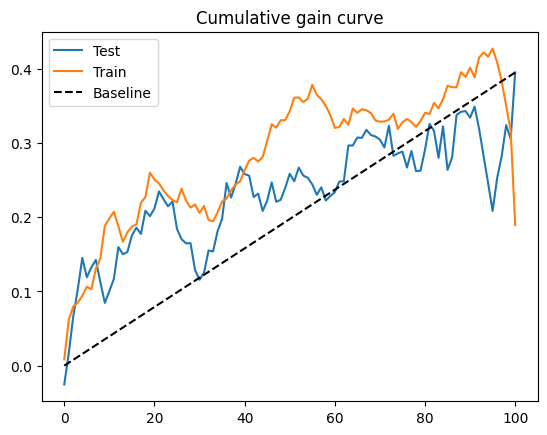

In [78]:
e = lambda x: 0.5
d = 8
weights_1 = np.concatenate((np.random.uniform(-15, 15, 2), [0,0,0,0,0,0]))
weights_2 = np.concatenate(([0,0], np.random.uniform(-15, 15, 2), [0,0,0,0]))
weights_3 = np.concatenate(([0,0,0,0], np.random.uniform(-15, 15, 2), [0,0]))
def mu_0(x):
    if x[7] < -0.4:
        return np.dot(x, weights_1)
    elif x[7] < 0.4:
        return np.dot(x, weights_2)
    else:
        return np.dot(x, weights_3)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [15]:
e = lambda x: 0.5
d = 8
weights_1 = np.concatenate((np.random.uniform(-15, 15, 2), [0,0,0,0,0,0]))
weights_2 = np.concatenate(([0,0], np.random.uniform(-15, 15, 2), [0,0,0,0]))
weights_3 = np.concatenate(([0,0,0,0], np.random.uniform(-15, 15, 2), [0,0]))
def mu_0(x):
    if x[7] < -0.4:
        return np.dot(x, weights_1)
    elif x[7] < 0.4:
        return np.dot(x, weights_2)
    else:
        return np.dot(x, weights_3)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,0.000705,0.000088
T-Learner,0.401892,0.087643
Causal Forest,0.128941,0.009999


# Case 7

Confounding

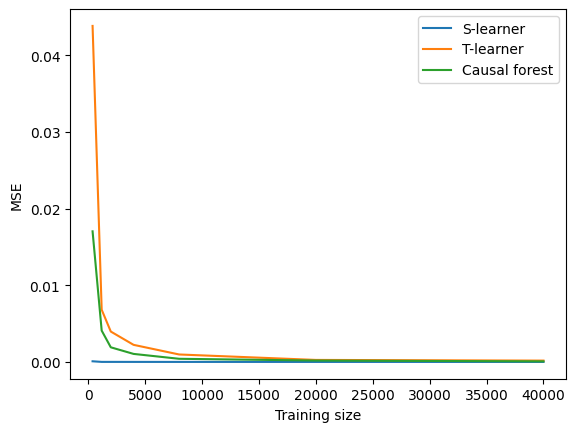

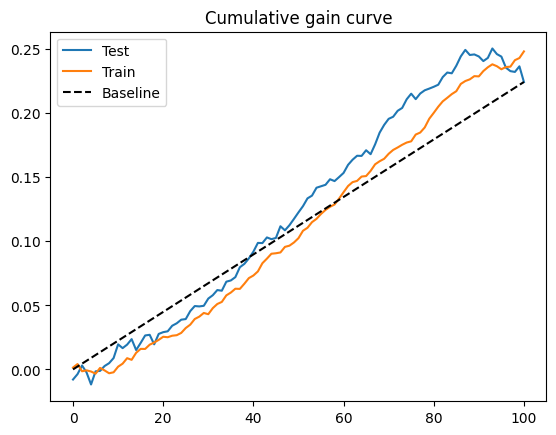

In [81]:
e = lambda x: 0.25 * (1 + beta(2, 4).pdf(x[0]))
d = 5
mu_0 = lambda x: 2 * x[0] - 1
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

run_test(d, mu_0, mu_1, e, n_train, n_test, 10)
plot_gain_curve(d, mu_0, mu_1, e, n_train, n_test)

In [16]:
e = lambda x: 0.25 * (1 + beta(2, 4).pdf(x[0]))
d = 5
mu_0 = lambda x: 2 * x[0] - 1
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000

get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, 10)

,Mean,Std dev
S-Learner,1.574209e-07,2.125743e-07
T-Learner,2.658683e-04,4.188327e-04
Causal Forest,8.273879e-05,7.548875e-05
